<a href="https://colab.research.google.com/github/gobucbabu/Master-s-project/blob/main/mastersproject_22019388.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Master's project
Colab file for my Data science Master's project


### Installations and library imports

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
# Library imports and functions
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import re

nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)

True

#### Memory clearing

In [3]:
import torch
torch.cuda.empty_cache()
print(f"GPU available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory/1e9:.2f} GB")

GPU available: True
GPU Memory: 15.84 GB


## IMDB dataset

### Data extraction

In [4]:
# Importing the IMDB dataset using the huggingface datasets library
from datasets import load_dataset

dataset = load_dataset("stanfordnlp/imdb")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

### EDA


Train set:
Reviews: 25000
Avg length: 1325.07 chars
Labels: label
0    0.5
1    0.5
Name: proportion, dtype: float64


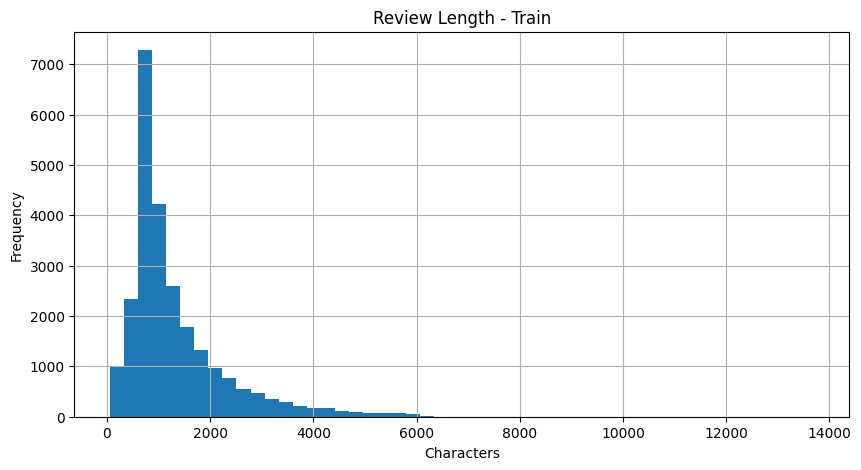


Test set:
Reviews: 25000
Avg length: 1293.79 chars
Labels: label
0    0.5
1    0.5
Name: proportion, dtype: float64


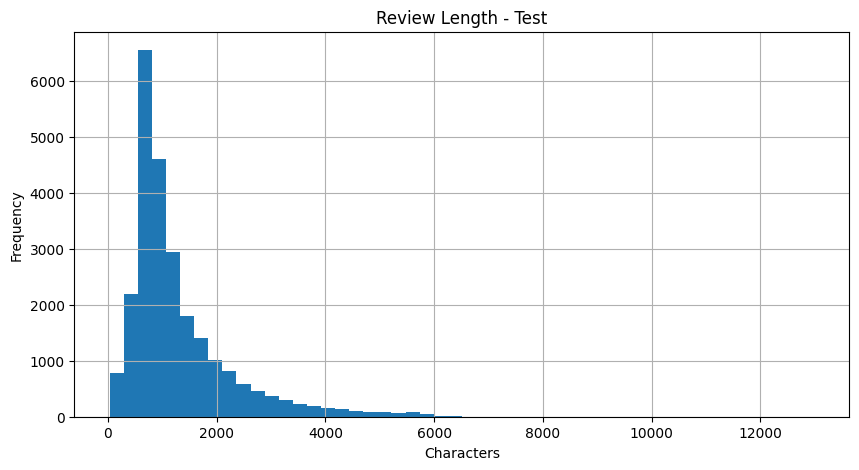


Unsupervised set:
Reviews: 50000
Avg length: 1329.90 chars
Labels: label
-1    1.0
Name: proportion, dtype: float64


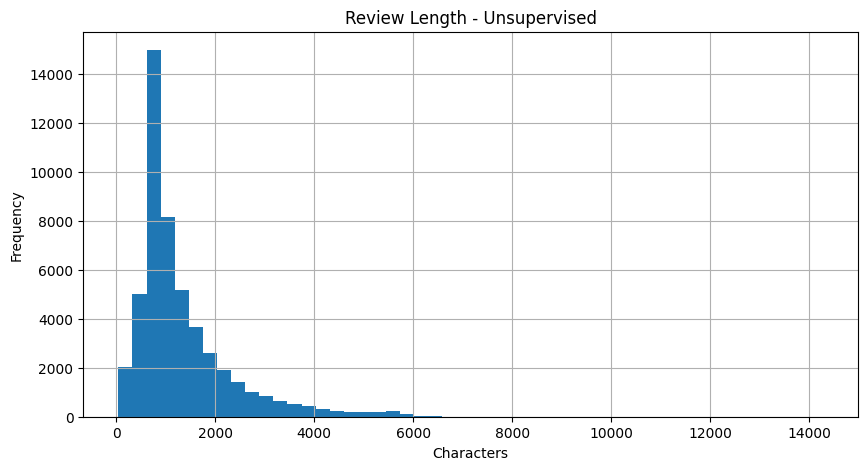

In [5]:
# Basic analysis
def analyze_split(split):
    df = pd.DataFrame(dataset[split])
    print(f"\n{split.capitalize()} set:")
    print(f"Reviews: {len(df)}")
    print(f"Avg length: {df['text'].str.len().mean():.2f} chars")
    print(f"Labels: {df['label'].value_counts(normalize=True)}")

    plt.figure(figsize=(10, 5))
    df['text'].str.len().hist(bins=50)
    plt.title(f"Review Length - {split.capitalize()}")
    plt.xlabel("Characters")
    plt.ylabel("Frequency")
    plt.show()

    return df

for split in ['train', 'test', 'unsupervised']:
    analyze_split(split)

In [6]:
"""# Word frequency analysis
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk

nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

# Load stopwords once, outside the loop
stop_words = set(stopwords.words('english'))

def word_frequency(texts, top_k=20):
    word_counts = Counter()
    for text in texts:
        # Tokenize and process each text
        words = word_tokenize(text.lower())
        words = [word for word in words if word.isalnum() and word not in stop_words]
        word_counts.update(words)
    return word_counts.most_common(top_k)

# Iterate over each split and calculate word frequencies
for split in ['train', 'test', 'unsupervised']:
    freq = word_frequency(dataset[split]['text'])
    plot_word_freq(freq, f"Top 20 Words - {split.capitalize()}")
"""

'# Word frequency analysis\nfrom collections import Counter\nfrom nltk.tokenize import word_tokenize\nfrom nltk.corpus import stopwords\nimport nltk\n\nnltk.download(\'punkt\', quiet=True)\nnltk.download(\'stopwords\', quiet=True)\n\n# Load stopwords once, outside the loop\nstop_words = set(stopwords.words(\'english\'))\n\ndef word_frequency(texts, top_k=20):\n    word_counts = Counter()\n    for text in texts:\n        # Tokenize and process each text\n        words = word_tokenize(text.lower())\n        words = [word for word in words if word.isalnum() and word not in stop_words]\n        word_counts.update(words)\n    return word_counts.most_common(top_k)\n\n# Iterate over each split and calculate word frequencies\nfor split in [\'train\', \'test\', \'unsupervised\']:\n    freq = word_frequency(dataset[split][\'text\'])\n    plot_word_freq(freq, f"Top 20 Words - {split.capitalize()}")\n'

In [7]:
# Sample reivews
print("\nSample reviews:")
for i in range(3):
    print(f"\nReview {i+1}:\n{dataset['train'][i]['text'][:200]}...")


Sample reviews:

Review 1:
I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ev...

Review 2:
"I Am Curious: Yellow" is a risible and pretentious steaming pile. It doesn't matter what one's political views are because this film can hardly be taken seriously on any level. As for the claim that ...

Review 3:
If only to avoid making this type of film in the future. This film is interesting as an experiment but tells no cogent story.<br /><br />One might feel virtuous for sitting thru it because it touches ...


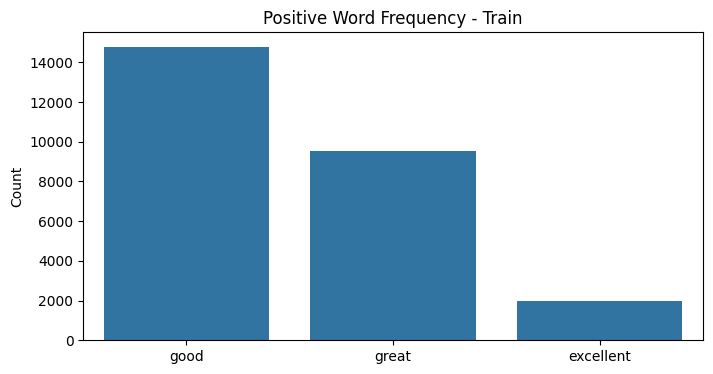

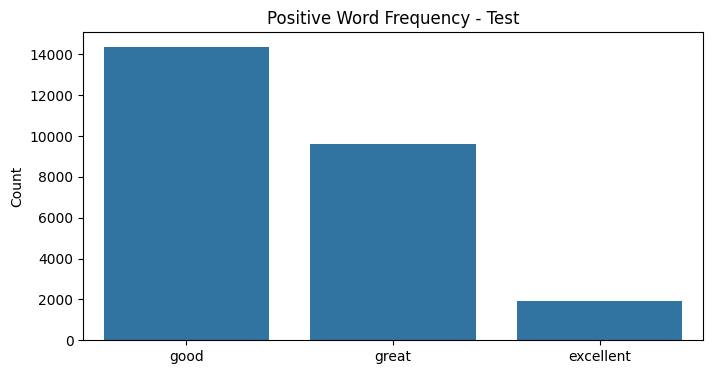

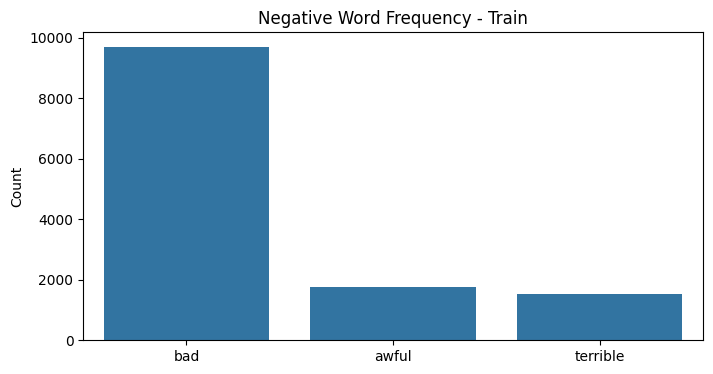

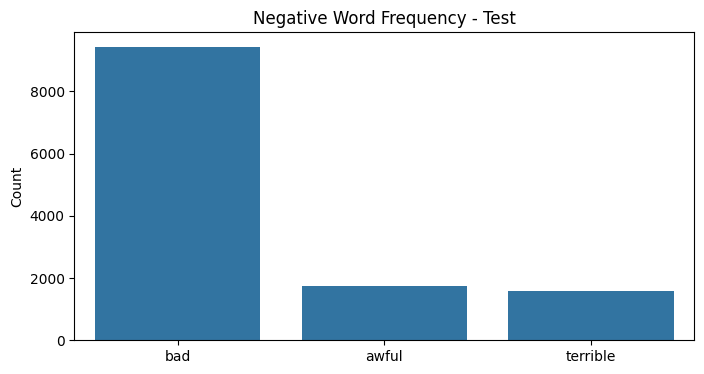

In [8]:
# Sentiment word analysis
import pandas as pd

sentiment_words = {'positive': ['good', 'great', 'excellent'], 'negative': ['bad', 'awful', 'terrible']}
for sentiment, words in sentiment_words.items():
    for split in ['train', 'test']:
        df = pd.DataFrame(dataset[split])
        counts = [df['text'].str.count(word).sum() for word in words]
        plt.figure(figsize=(8, 4))
        sns.barplot(x=words, y=counts)
        plt.title(f"{sentiment.capitalize()} Word Frequency - {split.capitalize()}")
        plt.ylabel("Count")
        plt.show()

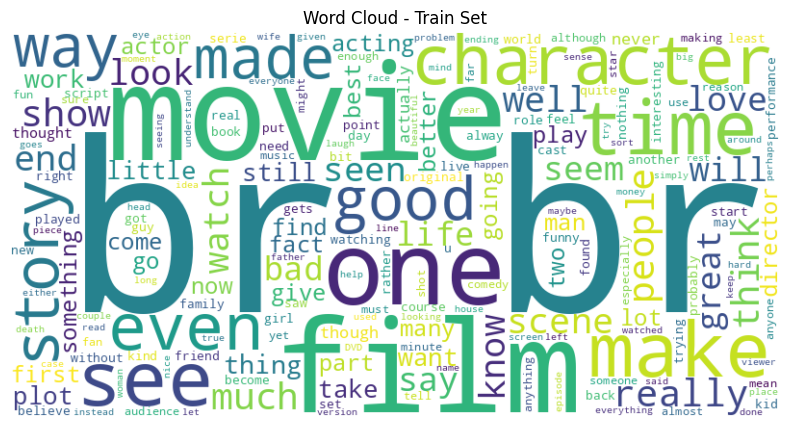

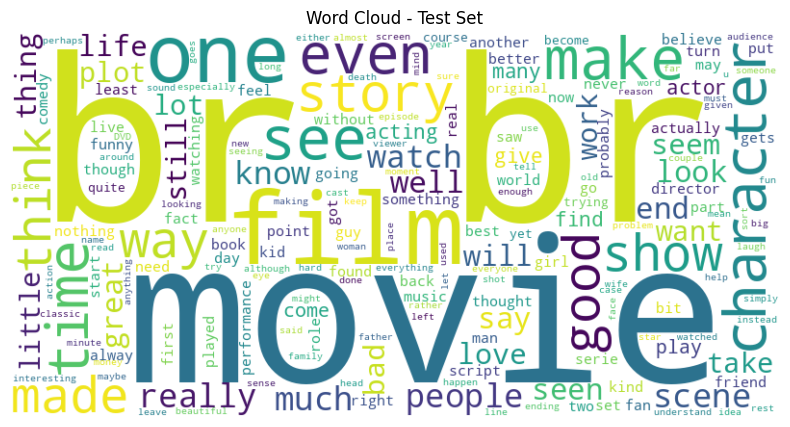

In [9]:
# Wordcloud visualisation
def generate_wordcloud(text, title):
    plt.figure(figsize=(10, 5))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

for split in ['train', 'test']:
    text = ' '.join(dataset[split]['text'])
    generate_wordcloud(text, f"Word Cloud - {split.capitalize()} Set")

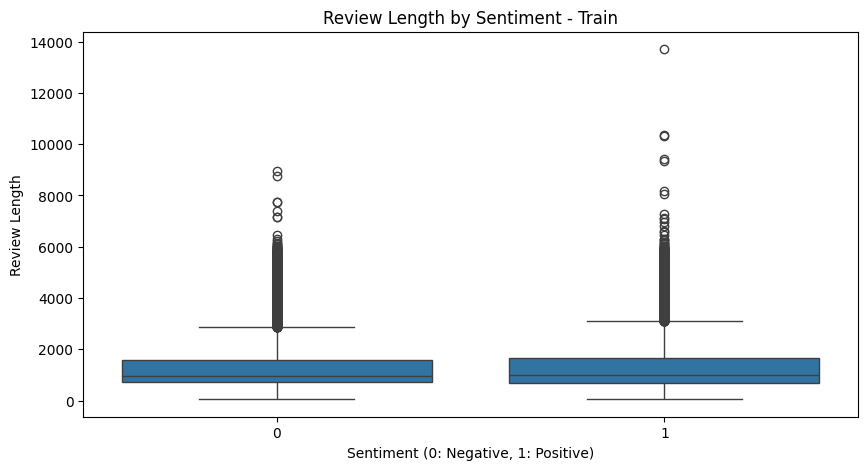

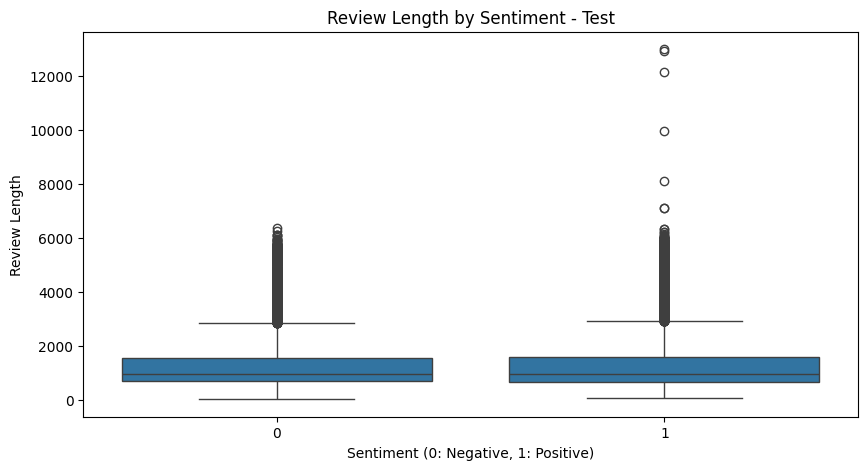

In [10]:
# Review length distribution by sentiment
for split in ['train', 'test']:
    df = pd.DataFrame(dataset[split])
    df['length'] = df['text'].str.len()
    plt.figure(figsize=(10, 5))
    sns.boxplot(x='label', y='length', data=df)
    plt.title(f"Review Length by Sentiment - {split.capitalize()}")
    plt.xlabel("Sentiment (0: Negative, 1: Positive)")
    plt.ylabel("Review Length")
    plt.show()

In [11]:
"""# N-gram analysis
# Excludes the HTML tags and line break characters
import re
from nltk import ngrams

def clean_text(text):
    # Remove HTML tags and line breaks
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'\n', ' ', text)
    return text

def get_top_ngrams(df, n, top_k=20):
    text = ' '.join(df['text']).lower()
    text = clean_text(text)
    words = nltk.word_tokenize(text)
    words = [word for word in words if word.isalnum()]
    n_grams = ngrams(words, n)
    return Counter(n_grams).most_common(top_k)

for n in [2, 3]:
    for split in ['train', 'test']:
        df = pd.DataFrame(dataset[split])
        top_ngrams = get_top_ngrams(df, n)
        plt.figure(figsize=(12, 6))
        sns.barplot(x=[' '.join(gram) for gram, count in top_ngrams], y=[count for gram, count in top_ngrams])
        plt.title(f"Top {n}-grams - {split.capitalize()}")
        plt.xticks(rotation=45, ha='right')
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()"""

'# N-gram analysis\n# Excludes the HTML tags and line break characters\nimport re\nfrom nltk import ngrams\n\ndef clean_text(text):\n    # Remove HTML tags and line breaks\n    text = re.sub(r\'<.*?>\', \'\', text)\n    text = re.sub(r\'\n\', \' \', text)\n    return text\n\ndef get_top_ngrams(df, n, top_k=20):\n    text = \' \'.join(df[\'text\']).lower()\n    text = clean_text(text)\n    words = nltk.word_tokenize(text)\n    words = [word for word in words if word.isalnum()]\n    n_grams = ngrams(words, n)\n    return Counter(n_grams).most_common(top_k)\n\nfor n in [2, 3]:\n    for split in [\'train\', \'test\']:\n        df = pd.DataFrame(dataset[split])\n        top_ngrams = get_top_ngrams(df, n)\n        plt.figure(figsize=(12, 6))\n        sns.barplot(x=[\' \'.join(gram) for gram, count in top_ngrams], y=[count for gram, count in top_ngrams])\n        plt.title(f"Top {n}-grams - {split.capitalize()}")\n        plt.xticks(rotation=45, ha=\'right\')\n        plt.ylabel("Frequency")\

### Pre-processing

#### Text cleaning pipeline

In [12]:
# Contraction handling
CONTRACTION_MAP = {
    "ain't": "is not",
    "aren't": "are not",
    "can't": "cannot",
    "couldn't": "could not",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'll": "he will",
    "he's": "he is",
    "i'd": "i would",
    "i'll": "i will",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it's": "it is",
    "let's": "let us",
    "shouldn't": "should not",
    "that's": "that is",
    "wasn't": "was not",
    "we'd": "we would",
    "we're": "we are",
    "weren't": "were not",
    "what's": "what is",
    "won't": "will not",
    "wouldn't": "would not",
    "you'd": "you would",
    "you're": "you are",
    "you've": "you have"
}

In [13]:
# HTML and Basic text cleaning
def remove_html(text):
    """Remove HTML tags"""
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub('', text)

def expand_contractions(text):
    """Expand contractions using the CONTRACTION_MAP"""
    for contraction, expansion in CONTRACTION_MAP.items():
        text = text.replace(contraction, expansion)
    return text

In [14]:
def clean_text(text):
    """Final cleaning function with all improvements"""
    # Remove HTML
    text = remove_html(text)

    # Handle foreign characters first
    text = text.encode('ascii', 'ignore').decode('ascii')

    # Handle specific patterns
    text = re.sub(r'U\.S\.|U\. S\.', 'USA', text)
    text = re.sub(r'(\d+)/(\d+)', r'\1 of \2', text)
    text = re.sub(r'\((\d+)\)', r'\1.', text)

    # Handle contractions and possessives
    text = expand_contractions(text)
    text = re.sub(r"([a-zA-Z]+)'s\b", r'\1s', text)

    # Convert to lowercase
    text = text.lower()

    # Fix comma spacings
    text = re.sub(r',(?!\s)', r', ', text)

    # Remove special characters but keep basic punctuation
    text = re.sub(r'[^a-zA-Z0-9\s.,!?]', ' ', text)

    # Clean up punctuation
    text = re.sub(r',\s*\.\s*', r'. ', text)  # Remove comma before period
    text = re.sub(r'([.!?])[.!?\s]*([.!?])[.!?\s]*', r'\1 ', text)
    text = re.sub(r'(\d+)\s*\.\s*(\w)', r'\1. \2', text)
    text = re.sub(r'\s*([.,!?])\s*', r'\1 ', text)

    # Clean up multiple spaces
    text = re.sub(r'\s+', ' ', text)

    return text.strip()

In [15]:
# Testing the cleaning functions on a sample review
sample_text = dataset['train'][0]['text']
print("Original:")
print(sample_text[:200])
print("\nCleaned:")
print(clean_text(sample_text)[:200])


Original:
I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ev

Cleaned:
i rented i am curious yellow from my video store because of all the controversy that surrounded it when it was first released in 1967. i also heard that at first it was seized by usa customs if it eve


In [16]:
# Applying the cleaning to a small subset to verify
def analyze_cleaning_results(original, cleaned):
    """Analyze the effects of cleaning with complete text comparison"""
    print(f"Original length: {len(original)}")
    print(f"Cleaned length: {len(cleaned)}")
    print("\nOriginal full text:")
    print(original)
    print("\nCleaned full text:")
    print(cleaned)
    print("\n" + "="*80 + "\n")  # Separator for readability

# Test on first 5 reviews
for i in range(5):
    text = dataset['train'][i]['text']
    cleaned = clean_text(text)
    print(f"\nREVIEW {i+1}:")
    analyze_cleaning_results(text, cleaned)


REVIEW 1:
Original length: 1640
Cleaned length: 1604

Original full text:
I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered p

In [17]:
# Applying cleaning to the whole set, saving and verifying
from datasets import load_dataset
import random
# Apply cleaning to entire dataset
def clean_dataset(dataset):
   """Apply cleaning to all splits of the dataset"""
   def clean_example(example):
       return {'text': clean_text(example['text'])}

   # Clean all splits
   cleaned_dataset = {}
   for split in dataset.keys():
       print(f"\nCleaning {split} split...")
       cleaned_dataset[split] = dataset[split].map(
           clean_example,
           desc=f"Cleaning {split} split"
       )

       # Verify number of examples
       print(f"Number of examples in {split}: {len(cleaned_dataset[split])}")

   return cleaned_dataset

# Clean the dataset
cleaned_dataset = clean_dataset(dataset)

# Save cleaned dataset
print("\nSaving cleaned dataset...")
for split in cleaned_dataset.keys():
   cleaned_dataset[split].save_to_disk(f"cleaned_imdb_{split}")
print("Dataset saved!")

# Verify cleaning with samples
def verify_cleaning(original_dataset, cleaned_dataset, num_samples=3):
   """Compare original and cleaned samples"""
   for split in original_dataset.keys():
       print(f"\nVerifying {split} split samples:")
       indices = random.sample(range(len(original_dataset[split])), num_samples)

       for idx in indices:
           print(f"\nSample {idx}:")
           print("Original:")
           print(original_dataset[split][idx]['text'][:200])
           print("\nCleaned:")
           print(cleaned_dataset[split][idx]['text'][:200])
           print("-" * 80)

# Verify samples
print("\nVerifying cleaning results...")
verify_cleaning(dataset, cleaned_dataset)


Cleaning train split...


Cleaning train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Number of examples in train: 25000

Cleaning test split...


Cleaning test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Number of examples in test: 25000

Cleaning unsupervised split...


Cleaning unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Number of examples in unsupervised: 50000

Saving cleaned dataset...


Saving the dataset (0/1 shards):   0%|          | 0/25000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/25000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset saved!

Verifying cleaning results...

Verifying train split samples:

Sample 12089:
Original:
This film is really ONLY Bill Maher's interpretation of religion. There are several funny moments, and some interesting points, but don't go into this expecting an even-handed discussion of religion. 

Cleaned:
this film is really only bill mahers interpretation of religion. there are several funny moments, and some interesting points, but do not go into this expecting an even handed discussion of religion. 
--------------------------------------------------------------------------------

Sample 4385:
Original:
"Serum" starts out with credits that are quite reminiscent of the "Re-animator" movies, and it owes a lot to them. The story is very similar; a mad doctor develops a serum that he believes will allevi

Cleaned:
serum starts out with credits that are quite reminiscent of the re animator movies, and it owes a lot to them. the story is very similar a mad doctor develops a serum th

#### Preparing for autocompletion

In [18]:
# Loadint the cleaned dataset and setting up parameters
from pathlib import Path
import torch
from datasets import load_from_disk
import random

# Load cleaned dataset
cleaned_train = load_from_disk("cleaned_imdb_train")
cleaned_test = load_from_disk("cleaned_imdb_test")

# Set parameters
INPUT_LENGTH = 100  # characters for input sequence
MIN_TARGET_LENGTH = 20  # minimum characters for target sequence
STRIDE = 50  # stride for sliding window
random.seed(42)  # for reproducibility

In [19]:
# Sequence pair generation funtion
from typing import List, Dict

def create_sequence_pairs(text: str) -> List[Dict[str, str]]:
    """
    Create input-target pairs from text using sliding window

    Args:
        text: Cleaned text string

    Returns:
        List of dictionaries containing input-target pairs
    """
    pairs = []
    text_length = len(text)

    # Skip if text is too short
    if text_length < (INPUT_LENGTH + MIN_TARGET_LENGTH):
        return pairs

    # Find sentence boundaries (periods followed by space)
    sentence_ends = [i for i, char in enumerate(text[:-1])
                    if char == '.' and text[i+1] == ' ']

    start_idx = 0
    while start_idx < (text_length - INPUT_LENGTH - MIN_TARGET_LENGTH):
        # Find appropriate split point near INPUT_LENGTH
        split_point = min((x for x in sentence_ends if x > start_idx + INPUT_LENGTH),
                         default=start_idx + INPUT_LENGTH)

        input_text = text[start_idx:split_point].strip()
        target_text = text[split_point:split_point + INPUT_LENGTH].strip()

        if len(target_text) >= MIN_TARGET_LENGTH:
            pairs.append({
                'input_text': input_text,
                'target_text': target_text,
                'input_length': len(input_text),
                'target_length': len(target_text)
            })

        start_idx += STRIDE

    return pairs

In [20]:
# Process the dataset and create pairs
def process_dataset(dataset):
    """Process dataset into sequence pairs"""
    all_pairs = []

    for idx, example in enumerate(dataset):
        pairs = create_sequence_pairs(example['text'])
        all_pairs.extend(pairs)

        # Progress update
        if (idx + 1) % 1000 == 0:
            print(f"Processed {idx + 1} reviews. Generated {len(all_pairs)} pairs so far.")

    return all_pairs

# Process training and test sets
print("Processing training set...")
train_pairs = process_dataset(cleaned_train)
print(f"\nTotal training pairs generated: {len(train_pairs)}")

print("\nProcessing test set...")
test_pairs = process_dataset(cleaned_test)
print(f"\nTotal test pairs generated: {len(test_pairs)}")

Processing training set...
Processed 1000 reviews. Generated 23360 pairs so far.
Processed 2000 reviews. Generated 45404 pairs so far.
Processed 3000 reviews. Generated 68388 pairs so far.
Processed 4000 reviews. Generated 91707 pairs so far.
Processed 5000 reviews. Generated 116033 pairs so far.
Processed 6000 reviews. Generated 139626 pairs so far.
Processed 7000 reviews. Generated 162863 pairs so far.
Processed 8000 reviews. Generated 187632 pairs so far.
Processed 9000 reviews. Generated 211693 pairs so far.
Processed 10000 reviews. Generated 233829 pairs so far.
Processed 11000 reviews. Generated 255832 pairs so far.
Processed 12000 reviews. Generated 279093 pairs so far.
Processed 13000 reviews. Generated 301774 pairs so far.
Processed 14000 reviews. Generated 327954 pairs so far.
Processed 15000 reviews. Generated 351391 pairs so far.
Processed 16000 reviews. Generated 375823 pairs so far.
Processed 17000 reviews. Generated 400718 pairs so far.
Processed 18000 reviews. Generated

#### Formatting  and saving the dataset





In [21]:
# Import tokenizer and setup
from transformers import GPT2Tokenizer
import torch
from torch.utils.data import Dataset, DataLoader
import pickle
import numpy as np

# Load tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('distilgpt2')
tokenizer.pad_token = tokenizer.eos_token

# Constants
MAX_INPUT_LENGTH = 512  # maximum tokens for input
MAX_TARGET_LENGTH = 128  # maximum tokens for target
BATCH_SIZE = 16

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [22]:
# Creating a custom dataset class
class IMDBAutocompleteDataset(Dataset):
    """Custom dataset for IMDB autocompletion task"""
    def __init__(self, pairs, tokenizer, max_input_length, max_target_length):
        self.pairs = pairs
        self.tokenizer = tokenizer
        self.max_input_length = max_input_length
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        pair = self.pairs[idx]

        # Tokenize input and target
        input_encoding = self.tokenizer(
            pair['input_text'],
            max_length=self.max_input_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        target_encoding = self.tokenizer(
            pair['target_text'],
            max_length=self.max_target_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': input_encoding['input_ids'].squeeze(),
            'attention_mask': input_encoding['attention_mask'].squeeze(),
            'labels': target_encoding['input_ids'].squeeze()
        }

In [23]:
# creating datasets and verifying
# Create datasets
train_dataset = IMDBAutocompleteDataset(
    train_pairs,
    tokenizer,
    MAX_INPUT_LENGTH,
    MAX_TARGET_LENGTH
)

test_dataset = IMDBAutocompleteDataset(
    test_pairs,
    tokenizer,
    MAX_INPUT_LENGTH,
    MAX_TARGET_LENGTH
)

# Create sample dataloader for verification
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Verify format
def verify_dataset(dataset, loader):
    print(f"Dataset size: {len(dataset)}")

    # Get first batch
    batch = next(iter(loader))
    print("\nBatch shapes:")
    for key, value in batch.items():
        print(f"{key}: {value.shape}")

    # Decode sample
    sample_idx = 0
    input_text = tokenizer.decode(batch['input_ids'][sample_idx])
    target_text = tokenizer.decode(batch['labels'][sample_idx])

    print("\nSample decoded text:")
    print("Input:", input_text[:100], "...")
    print("Target:", target_text[:100], "...")

print("Verifying training dataset:")
verify_dataset(train_dataset, train_loader)

Verifying training dataset:
Dataset size: 593349

Batch shapes:
input_ids: torch.Size([16, 512])
attention_mask: torch.Size([16, 512])
labels: torch.Size([16, 128])

Sample decoded text:
Input: give me my scallop shell of quiet, my staff of faith to walk upon, my scrip of joy, immortal diet, m ...
Target: . i imagine both of them facing trial during doomsday and saying nonchalantly to an irate god i beg< ...


In [24]:
# Saving processed daatsets
def save_processed_data(dataset, filename):
    """Save processed dataset"""
    save_dict = {
        'dataset': dataset,
        'tokenizer_name': 'distilgpt2',
        'max_input_length': MAX_INPUT_LENGTH,
        'max_target_length': MAX_TARGET_LENGTH
    }

    with open(filename, 'wb') as f:
        pickle.dump(save_dict, f)

# Save datasets
print("Saving processed datasets...")
save_processed_data(train_dataset, 'imdb_autocomplete_train.pkl')
save_processed_data(test_dataset, 'imdb_autocomplete_test.pkl')
print("Datasets saved!")

# Save tokenizer config separately
tokenizer.save_pretrained('./tokenizer')
print("Tokenizer saved!")

Saving processed datasets...
Datasets saved!
Tokenizer saved!


Analyzing training dataset...


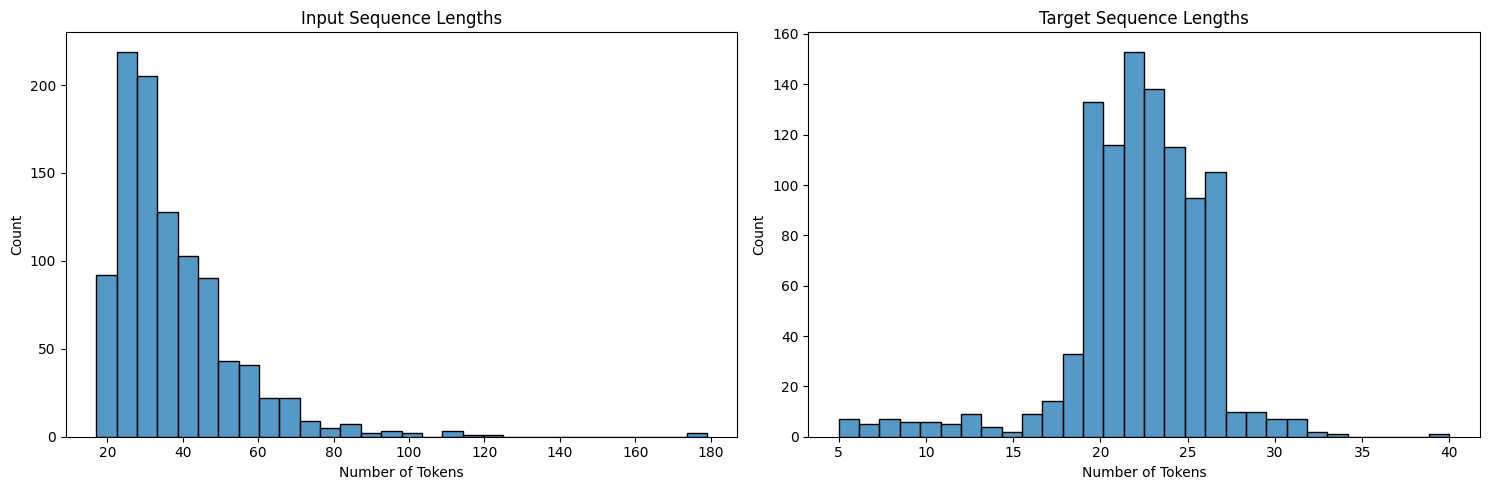


Sequence Length Statistics:
Input - Mean: 37.30, Median: 33.00, Max: 179
Target - Mean: 22.11, Median: 22.00, Max: 40

Validation Checks:
Samples with empty inputs: 0
Samples with empty targets: 0
Samples with full-length inputs: 0
Samples with full-length targets: 0

Detailed Quality Checks:

Sample 1:
Input: ty everywhere but he is my favourite hong kong moviestar so far way better than nicolas tse neverthe ...
Target: . without a doubt this film is a work of art from the beginning to the end. i even thought that only ...
Checks:
- Input contains padding: True
- Target contains padding: True
- Input/Target relation makes sense: True
--------------------------------------------------------------------------------

Sample 2:
Input: t his deserved 3rd bond outing it was a laugh. belushi brought some good humour to his part and dalt ...
Target: . his part was liked a camped up version of jack nicholson in a few good men. the other brit in it w ...
Checks:
- Input contains padding: True


In [25]:
# Some additional validation and checks
# Cell - Additional Validation and Statistics
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

def analyze_dataset_statistics(dataset, tokenizer, num_samples=1000):
    """Analyze tokenized dataset statistics"""
    # Sample random indices
    indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))

    # Collect statistics
    input_token_lengths = []
    target_token_lengths = []
    input_vocab = Counter()
    target_vocab = Counter()

    for idx in indices:
        sample = dataset[idx]

        # Count non-padding tokens
        input_length = (sample['input_ids'] != tokenizer.pad_token_id).sum().item()
        target_length = (sample['labels'] != tokenizer.pad_token_id).sum().item()

        input_token_lengths.append(input_length)
        target_token_lengths.append(target_length)

        # Collect vocabulary statistics
        input_vocab.update(sample['input_ids'].tolist())
        target_vocab.update(sample['labels'].tolist())

    # Plot distributions
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    sns.histplot(input_token_lengths, bins=30)
    plt.title('Input Sequence Lengths')
    plt.xlabel('Number of Tokens')
    plt.ylabel('Count')

    plt.subplot(1, 2, 2)
    sns.histplot(target_token_lengths, bins=30)
    plt.title('Target Sequence Lengths')
    plt.xlabel('Number of Tokens')
    plt.ylabel('Count')

    plt.tight_layout()
    plt.show()

    # Print statistics
    print("\nSequence Length Statistics:")
    print(f"Input - Mean: {np.mean(input_token_lengths):.2f}, "
          f"Median: {np.median(input_token_lengths):.2f}, "
          f"Max: {max(input_token_lengths)}")
    print(f"Target - Mean: {np.mean(target_token_lengths):.2f}, "
          f"Median: {np.median(target_token_lengths):.2f}, "
          f"Max: {max(target_token_lengths)}")

    # Validation checks
    print("\nValidation Checks:")
    print(f"Samples with empty inputs: {sum(l == 0 for l in input_token_lengths)}")
    print(f"Samples with empty targets: {sum(l == 0 for l in target_token_lengths)}")
    print(f"Samples with full-length inputs: {sum(l == MAX_INPUT_LENGTH for l in input_token_lengths)}")
    print(f"Samples with full-length targets: {sum(l == MAX_TARGET_LENGTH for l in target_token_lengths)}")

# Run analysis
print("Analyzing training dataset...")
analyze_dataset_statistics(train_dataset, tokenizer)

# Additional quality checks
def check_data_quality(dataset, tokenizer, num_samples=5):
    """Perform detailed quality checks on random samples"""
    print("\nDetailed Quality Checks:")

    indices = random.sample(range(len(dataset)), num_samples)
    for i, idx in enumerate(indices):
        sample = dataset[idx]

        # Decode texts
        input_text = tokenizer.decode(sample['input_ids'])
        target_text = tokenizer.decode(sample['labels'])

        print(f"\nSample {i+1}:")
        print("Input:", input_text[:100], "..." if len(input_text) > 100 else "")
        print("Target:", target_text[:100], "..." if len(target_text) > 100 else "")

        # Check for potential issues
        print("Checks:")
        print(f"- Input contains padding: {tokenizer.pad_token in input_text}")
        print(f"- Target contains padding: {tokenizer.pad_token in target_text}")
        print(f"- Input/Target relation makes sense: {target_text.strip().startswith('.')}")
        print("-" * 80)

# Run quality checks
check_data_quality(train_dataset, tokenizer)

## Fine-tuning DistilGPT-2 on the IMDB dataset

### Model setup

#### Memory check and imports

In [26]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader
import numpy as np
import os
from tqdm import tqdm

# Clear GPU memory
torch.cuda.empty_cache()
print(f"GPU available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory/1e9:.2f} GB")

GPU available: True
GPU Memory: 15.84 GB


#### Define training config and initialize


In [27]:
class TrainingConfig:
    """Training configuration with memory optimization"""
    # Model parameters
    model_name = 'distilgpt2'
    max_length = 256
    batch_size = 4
    gradient_accumulation_steps = 4

    # Optimizer parameters
    learning_rate = 5e-5
    max_grad_norm = 1.0
    weight_decay = 0.01

    # Training parameters
    num_epochs = 3
    warmup_steps = 1000
    warmup_ratio = 0.1

    # Logging and saving
    save_steps = 1000
    eval_steps = 1000
    checkpoint_dir = "checkpoints"

    # Hardware
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    num_workers = 2

# Initialize config
config = TrainingConfig()

#### Loading the datasets

In [28]:
import pickle

# Load preprocessed datasets
print("Loading preprocessed datasets...")
try:
    with open('imdb_autocomplete_train.pkl', 'rb') as f:
        train_data = pickle.load(f)
        train_dataset = train_data['dataset']

    with open('imdb_autocomplete_test.pkl', 'rb') as f:
        test_data = pickle.load(f)
        test_dataset = test_data['dataset']

    print(f"Loaded datasets:")
    print(f"Training samples: {len(train_dataset)}")
    print(f"Testing samples: {len(test_dataset)}")

    # Verify other saved configurations
    print(f"\nTokenizer name: {train_data['tokenizer_name']}")
    print(f"Max input length: {train_data['max_input_length']}")
    print(f"Max target length: {train_data['max_target_length']}")

except FileNotFoundError:
    print("Dataset files not found. Make sure you've run the preprocessing and saving steps first.")
except Exception as e:
    print(f"Error loading datasets: {e}")

Loading preprocessed datasets...
Loaded datasets:
Training samples: 593349
Testing samples: 577732

Tokenizer name: distilgpt2
Max input length: 512
Max target length: 128


In [29]:
# First verification - Check Dataset
print("Verifying dataset samples...")
for i in range(3):
    sample = train_dataset[i]
    print(f"\nSample {i+1}:")
    print(f"Input shape: {sample['input_ids'].shape}")
    print(f"Label shape: {sample['labels'].shape}")
    print(f"Mask shape: {sample['attention_mask'].shape}")

Verifying dataset samples...

Sample 1:
Input shape: torch.Size([512])
Label shape: torch.Size([128])
Mask shape: torch.Size([512])

Sample 2:
Input shape: torch.Size([512])
Label shape: torch.Size([128])
Mask shape: torch.Size([512])

Sample 3:
Input shape: torch.Size([512])
Label shape: torch.Size([128])
Mask shape: torch.Size([512])


#### Setting up model and tokenizer

In [30]:
# Setting up tokenizers
tokenizer = GPT2Tokenizer.from_pretrained(config.model_name)
tokenizer.pad_token = tokenizer.eos_token

# Model setup
model = GPT2LMHeadModel.from_pretrained(config.model_name)
model.to(config.device)

# Print model size
model_size = sum(t.numel() for t in model.parameters())
print(f"Model size: {model_size:,} parameters")

# Memory optimized data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=config.batch_size,
    shuffle=True,
    num_workers=config.num_workers,
    pin_memory=True if config.device=='cuda' else False,
    drop_last=True
)

val_loader = DataLoader(
    test_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=config.num_workers,
    pin_memory=True if config.device=='cuda' else False,
    drop_last=True
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Model size: 81,912,576 parameters


In [31]:
# Verification
# Second verification - Check Batch Processing
print("\nVerifying batch formation...")
batch = next(iter(train_loader))
print("\nBatch details:")
print(f"Input: {batch['input_ids'].shape}")
print(f"Labels: {batch['labels'].shape}")
print(f"Mask: {batch['attention_mask'].shape}")
print("\nNon-pad tokens in input:", (batch['input_ids'] != tokenizer.pad_token_id).sum())
print("Non-pad tokens in labels:", (batch['labels'] != tokenizer.pad_token_id).sum())


Verifying batch formation...

Batch details:
Input: torch.Size([4, 512])
Labels: torch.Size([4, 128])
Mask: torch.Size([4, 512])

Non-pad tokens in input: tensor(98)
Non-pad tokens in labels: tensor(77)


#### Setting up optimizer and scheduler

In [32]:
# Initialize optimizer
from torch.optim import AdamW  # Using PyTorch's AdamW

optimizer = AdamW(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

# Calculate total training steps
num_training_steps = len(train_loader) * config.num_epochs
num_warmup_steps = config.warmup_steps

# Initialize scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

print(f"Total training steps: {num_training_steps}")
print(f"Warmup steps: {num_warmup_steps}")

Total training steps: 445011
Warmup steps: 1000


#### Setting training utilities

In [33]:
class TrainingStats:
    """Class to track training statistics"""
    def __init__(self):
        self.running_loss = 0
        self.steps = 0
        self.epoch_losses = []

    def update(self, loss):
        self.running_loss += loss
        self.steps += 1

    def average(self):
        return self.running_loss / self.steps if self.steps > 0 else 0

    def log_epoch(self):
        avg_loss = self.average()
        self.epoch_losses.append(avg_loss)
        return avg_loss

    def reset(self):
        self.running_loss = 0
        self.steps = 0

def save_checkpoint(model, optimizer, scheduler, epoch, loss, path):
    """Save model checkpoint"""
    checkpoint_path = os.path.join(path, f'checkpoint-epoch-{epoch}.pt')
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'loss': loss,
    }, checkpoint_path)
    print(f"Checkpoint saved: {checkpoint_path}")

# Create directory for checkpoints
os.makedirs('checkpoints', exist_ok=True)

# Initialize training statistics
train_stats = TrainingStats()
val_stats = TrainingStats()

In [34]:
# Verification
# Third verification - Check Loss Computation
def verify_shapes(batch):
    """Debug shape transformations"""
    input_ids = batch['input_ids'].to(config.device)
    labels = batch['labels'].to(config.device)

    print("Original shapes:")
    print(f"Input ids: {input_ids.shape}")
    print(f"Labels: {labels.shape}")

    # Shift for next-token prediction
    shift_logits = input_ids[..., :-1].contiguous()
    shift_labels = labels[..., 1:].contiguous()

    print("\nAfter shifting:")
    print(f"Shifted logits: {shift_logits.shape}")
    print(f"Shifted labels: {shift_labels.shape}")

    # Show flattened dimensions
    print("\nFlattened shapes:")
    print(f"Flattened logits: {shift_logits.view(-1).shape}")
    print(f"Flattened labels: {shift_labels.view(-1).shape}")

# Run shape verification
print("\nVerifying shape transformations...")
sample_batch = next(iter(train_loader))
verify_shapes(sample_batch)


Verifying shape transformations...
Original shapes:
Input ids: torch.Size([4, 512])
Labels: torch.Size([4, 128])

After shifting:
Shifted logits: torch.Size([4, 511])
Shifted labels: torch.Size([4, 127])

Flattened shapes:
Flattened logits: torch.Size([2044])
Flattened labels: torch.Size([508])


### Training configuration

#### Defining loss function and metrics

In [35]:
def compute_loss(model_output, labels):
    """Compute loss with proper shape handling"""
    # Get logits from model output
    logits = model_output.logits

    # Shift logits and labels for next token prediction
    # Shift logits to the left and labels to the right
    shift_logits = logits[..., :-1, :].contiguous()
    shift_labels = labels[..., 1:].contiguous()

    # Flatten the tensors
    vocab_size = shift_logits.size(-1)
    shift_logits = shift_logits.view(-1, vocab_size)
    shift_labels = shift_labels.view(-1)

    # Compute loss
    loss_fct = torch.nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
    loss = loss_fct(shift_logits, shift_labels)

    return loss

def compute_perplexity(loss):
    """Compute perplexity from loss"""
    return torch.exp(loss)

#### Setting up evsluation metrics

In [36]:
class EvaluationMetrics:
    """Track evaluation metrics"""
    def __init__(self):
        self.losses = []
        self.perplexities = []
        self.best_loss = float('inf')

    def update(self, loss, perplexity):
        self.losses.append(loss)
        self.perplexities.append(perplexity)

        # Check if this is the best model
        if loss < self.best_loss:
            self.best_loss = loss
            return True
        return False

    def get_metrics(self):
        return {
            'avg_loss': sum(self.losses) / len(self.losses),
            'avg_perplexity': sum(self.perplexities) / len(self.perplexities),
            'best_loss': self.best_loss
        }

metrics = EvaluationMetrics()

#### Defining a validation function

In [37]:
def validate(model, val_loader, metrics):
    """Run validation loop"""
    model.eval()
    val_stats = TrainingStats()

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validating"):
            # Move batch to device
            input_ids = batch['input_ids'].to(config.device)
            labels = batch['labels'].to(config.device)
            attention_mask = batch['attention_mask'].to(config.device)

            # Forward pass
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            # Compute metrics
            loss = outputs.loss
            perplexity = compute_perplexity(loss)

            val_stats.update(loss.item())
            metrics.update(loss.item(), perplexity.item())

    avg_loss = val_stats.average()
    print(f"Validation Loss: {avg_loss:.4f}")
    return avg_loss

print("Training configuration complete. Ready to start training loop.")

Training configuration complete. Ready to start training loop.


### Training loop implementation

#### Defining main training steps

In [38]:
def training_step(model, batch, optimizer, scheduler, step):
    """Single training step handling different input/target lengths"""
    # Move batch to device
    input_ids = batch['input_ids'].to(config.device)
    labels = batch['labels'].to(config.device)
    attention_mask = batch['attention_mask'].to(config.device)

    # Get shapes
    batch_size, input_seq_len = input_ids.shape
    _, target_seq_len = labels.shape

    # Forward pass
    outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        labels=None,
        return_dict=True
    )

    # Get logits and prepare for loss calculation
    logits = outputs.logits

    # Take the relevant portion of logits that corresponds to target length
    relevant_logits = logits[:, -target_seq_len-1:-1, :].contiguous()  # Added contiguous()

    # Prepare labels (shift right for next token prediction)
    shift_labels = labels[..., 1:].contiguous()  # Added contiguous()

    # Reshape logits and labels for loss calculation
    vocab_size = relevant_logits.size(-1)
    flat_logits = relevant_logits.reshape(-1, vocab_size)  # Changed view to reshape
    flat_labels = shift_labels.reshape(-1)  # Changed view to reshape

    # Add debug prints
    print(f"Shapes before loss:")
    print(f"flat_logits: {flat_logits.shape}")
    print(f"flat_labels: {flat_labels.shape}")

    # Compute loss (ignore padding tokens)
    loss_fct = torch.nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
    loss = loss_fct(flat_logits, flat_labels)

    # Scale loss and backward pass
    loss = loss / config.gradient_accumulation_steps
    loss.backward()

    # Update weights if needed
    if (step + 1) % config.gradient_accumulation_steps == 0:
        torch.nn.utils.clip_grad_norm_(model.parameters(), config.max_grad_norm)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return loss.item() * config.gradient_accumulation_steps

#### Defining training epochs

In [39]:
def train_epoch(model, train_loader, optimizer, scheduler, epoch):
    """Training loop for one epoch"""
    model.train()
    epoch_stats = TrainingStats()

    progress_bar = tqdm(train_loader, desc=f"Training Epoch {epoch}")

    for step, batch in enumerate(progress_bar):
        # Perform training step
        loss = training_step(model, batch, optimizer, scheduler, step)  # Added step parameter
        epoch_stats.update(loss)

        # Update progress bar
        progress_bar.set_postfix({'loss': f"{epoch_stats.average():.4f}"})

        # Validate and save if needed
        if step > 0 and step % config.eval_steps == 0:
            val_loss = validate(model, val_loader, metrics)

            # Save checkpoint if best
            if metrics.losses[-1] == metrics.best_loss:
                save_checkpoint(
                    model, optimizer, scheduler,
                    epoch, val_loss,
                    config.checkpoint_dir
                )

            model.train()  # Return to training mode

    return epoch_stats.average()

#### Main training loop

In [40]:
def train_model(model, train_loader, val_loader, config):
    """Complete training loop"""
    # Setup optimizer and scheduler
    optimizer = AdamW(
        model.parameters(),
        lr=config.learning_rate,
        weight_decay=config.weight_decay
    )

    total_steps = len(train_loader) * config.num_epochs
    warmup_steps = int(total_steps * config.warmup_ratio)

    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_steps
    )

    print(f"Starting training for {config.num_epochs} epochs...")
    print(f"Total steps: {total_steps}")
    print(f"Warmup steps: {warmup_steps}")

    for epoch in range(config.num_epochs):
        print(f"\nEpoch {epoch+1}/{config.num_epochs}")

        # Train for one epoch
        train_loss = train_epoch(model, train_loader, optimizer, scheduler, epoch+1)
        print(f"Average training loss: {train_loss:.4f}")

        # Validate
        val_loss = validate(model, val_loader, metrics)

        # Save checkpoint
        save_checkpoint(
            model, optimizer, scheduler,
            epoch+1, val_loss,
            config.checkpoint_dir
        )

    return metrics.get_metrics()

In [41]:
# Verifying shapes before starting to train
sample_batch = next(iter(train_loader))
print("Sample batch shapes:")
for key, value in sample_batch.items():
    print(f"{key}: {value.shape}")

Sample batch shapes:
input_ids: torch.Size([4, 512])
attention_mask: torch.Size([4, 512])
labels: torch.Size([4, 128])


#### Training

In [42]:
# Ensure model is on correct device
model = model.to(config.device)

# Start training
final_metrics = train_model(model, train_loader, val_loader, config)

print("\nTraining completed!")
print("\nFinal Metrics:")
for metric_name, value in final_metrics.items():
    print(f"{metric_name}: {value:.4f}")

# Save final model
model.save_pretrained(os.path.join(config.checkpoint_dir, "final_model"))
tokenizer.save_pretrained(os.path.join(config.checkpoint_dir, "final_model"))
print("\nFinal model saved!")

Starting training for 3 epochs...
Total steps: 445011
Warmup steps: 44501

Epoch 1/3


Training Epoch 1:   0%|          | 0/148337 [00:01<?, ?it/s]


RuntimeError: view size is not compatible with input tensor's size and stride (at least one dimension spans across two contiguous subspaces). Use .reshape(...) instead.